In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from dataclasses import dataclass
from datasets import load_dataset

In [14]:
from common_utils.eval import EvalClient, EvalRunner
from common_utils.image_utils import show_image

In [15]:
from common_utils.buckets import CategoryEvalRunner

In [16]:
from common_utils.judge import JudgeClient, LLMJudge

#### Generate Different Model Outputs

In [17]:
@dataclass
class EvalConfig:
    base_url: str = "http://localhost:8010/v1"
    api_key: str = "EMPTY"
    # model: str = "Qwen/Qwen2.5-VL-3B-Instruct"
    # model: str = "google/gemma-3-27b-it"
    # model: str = "Qwen/Qwen3-4B-Thinking-2507"
    model: str = "Qwen/Qwen2.5-VL-7B-Instruct"
    temperature: float = 0.5
    max_tokens: int = 2048
    
eval_client = EvalConfig()

@dataclass
class JudgeConfig:
    base_url: str = "http://localhost:8000/v1"
    api_key: str = "EMPTY"
    model: str = "google/gemma-3-27b-it"    
    max_retries: int = 3
    backoff: float = 0.6
    max_tokens: int = 2048
    temperature: float = 0.0

judge_client = JudgeConfig()


### Test the Evaluation

In [18]:
# 1) dataset (your existing filtering)
dataset = load_dataset("lmarena-ai/VisionArena-Chat", split="train", streaming=True)
en_dataset = dataset.filter(lambda ex: ex["num_turns"] == 1 and ex["language"] == "English")
LEN_SMALL_DS = 2000
small_ds = en_dataset.take(LEN_SMALL_DS)

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

In [19]:
# 3) wire eval
client = EvalClient(eval_client.base_url, eval_client.api_key)
runner = EvalRunner(eval_client, client)

In [20]:
# C) choose categories & run 10 per
categories = ["humor", "captioning", "entity_recognition", "homework"]  # add/remove as needed
cat_runner = CategoryEvalRunner(runner, k=10, id_key="conversation_id", exclusive=True)

### Test one Sample

In [21]:
import random
import itertools

k = random.randrange(LEN_SMALL_DS/10)
sample = next(itertools.islice(small_ds, k, k+1))

=== Eval Output ===
conv_id: 28967f543f424b028b789aa7a51e2f09
dataset_model: llava-onevision-qwen2-72b-ov
user_question: Answer the question correctly  ...
reference_answer: The image shows a computer screen with a document open. The document appears to contain a diagram with decision-making e ...
model_answer: To answer the question correctly, we need to analyze the cost-benefit analysis shown in the image and evaluate it against the given criteria: correctness, informativeness, and chain of thought.

### A ...
latency: 16.5116 sec


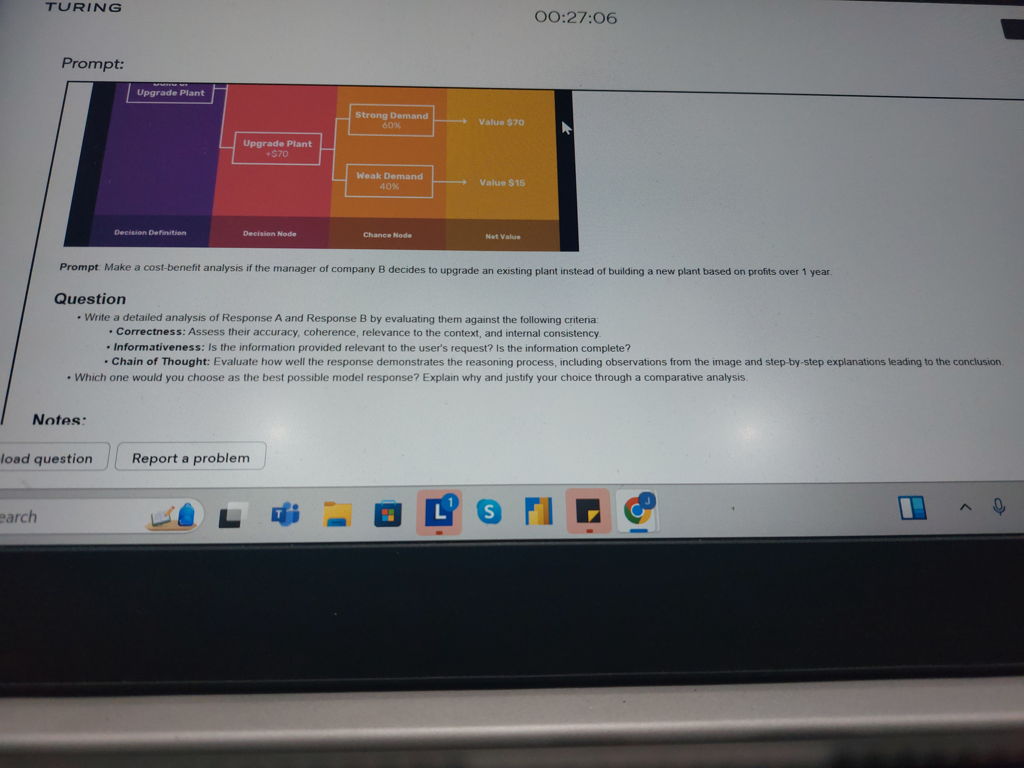

In [22]:
# 4) run eval on the sample
out = runner.run_on_sample(sample)
print("=== Eval Output ===")
print("conv_id:", out.conversation_id)
print("dataset_model:", out.dataset_model)
print("user_question:", out.user_question[:120], "...")
print("reference_answer:", out.reference_answer[:120], "...")
print("model_answer:", out.model_answer[:200], "...")
print("latency:", out.latency_sec, "sec")
show_image(out.images[0].get('bytes'))

### Test one batches

In [23]:
buckets = cat_runner.build_buckets(iter(small_ds), categories)

[BUCKETS] Building buckets...
  - target_categories: ['humor', 'captioning', 'entity_recognition', 'homework']
  - k per category   : 10
  - exclusive        : True
  - id_key           : conversation_id
[BUCKETS] Done in 23.72s
[BUCKETS] Counts:
  - humor             10/10 ✓
  - captioning        10/10 ✓
  - entity_recognition  10/10 ✓
  - homework          10/10 ✓
[BUCKETS] Preview (first few IDs per category):
  - homework         ['fa477bd697d8453182064a05a525ab59', '9974c6a20a16457caccf071b49d5ddb5']
  - captioning       ['0b12881c7b7448a7a536f4428419cc78', '27fdaf54262a4c849a190a620b6e1122']
  - humor            ['6447e58c1ce642dcada83e27129fe0be', '708ee0874f3b4518be4deaa9cc153fd1']
  - entity_recognition ['243d52265605476ab6ccf3679cd893bc', '801438bfac9c44cd98b43f30c2c19033']


### Execution

In [24]:
results_by_cat, all_results = cat_runner._run_buckets(buckets)

[EVAL] Starting per-category evaluation...
[EVAL] Category 'homework' → 10 item(s)
  - [homework] 1/10 conv_id=fa477bd697d8453182064a05a525ab59 latency=2.571s (wall 2.571s)  Q: Please, convert these formulas to markdown LaTeX, use russian for text
  - [homework] 2/10 conv_id=9974c6a20a16457caccf071b49d5ddb5 latency=1.902s (wall 1.902s)  Q: give answer
  - [homework] 3/10 conv_id=156fd6367b2341a58652f5fe20dc4a0c latency=2.975s (wall 2.975s)  Q: solve
  - [homework] 4/10 conv_id=6be6bc3785ab42c9a5b4b47bcae4f431 latency=23.778s (wall 23.779s)  Q: Solucione
  - [homework] 5/10 conv_id=b0fc9ea0c8454cbc87128d5e3ef93179 latency=11.141s (wall 11.142s)  Q: solve this question using C
  - [homework] 6/10 conv_id=5ffc0bce85d14e699c65c5c138c4b882 latency=5.790s (wall 5.796s)  Q: answer
  - [homework] 7/10 conv_id=8cf0c01bc7094a77b59f876e05a9af2d latency=2.739s (wall 2.743s)  Q: Answer 
  - [homework] 8/10 conv_id=934db128523e49ccb47cafe0f56013d3 latency=8.680s (wall 8.681s)  Q: Generate Python cod

In [25]:
print(f"\nCollected {sum(len(v) for v in results_by_cat.values())} samples "
      f"across {len(results_by_cat)} categories; flat array size: {len(all_results)}")


Collected 40 samples across 4 categories; flat array size: 40


First result:
 conv_id: 9974c6a20a16457caccf071b49d5ddb5
 category: homework
 user_question: give answer ...
 model_answer: The most logically drawn conclusion from the experience of the war in Afghanistan would be:

B. The support of the American people is not necessary for military victory.

This conclusion is based on the fact that the war in Afghanistan, which was a significant and costly conflict for the United States, did not have broad public support in the U.S. and yet the U.S. military managed to pursue its objectives despite this lack of domestic backing. However, it's important to note that this conclusion does not necessarily imply that public support is irrelevant in all military conflicts, but rather that the specific circumstances of the Afghan War may have influenced the perception or necessity of public support. ...
 latency: 1.9021


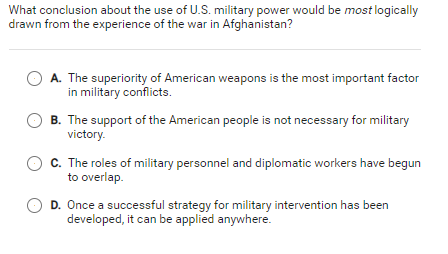

In [26]:
# Example: peek first item from the flat array
if all_results:
    r0 = all_results[1]
    print("First result:")
    print(" conv_id:", r0.conversation_id)
    print(" category:", next((c for c, rs in results_by_cat.items() if r0 in rs), None))
    print(" user_question:", r0.user_question, "...")
    print(" model_answer:", r0.model_answer, "...")
    print(" latency:", r0.latency_sec)
    show_image(r0.images[0].get('bytes'))

#### Judge Evaluation

In [27]:
judge_client

JudgeConfig(base_url='http://localhost:8000/v1', api_key='EMPTY', model='google/gemma-3-27b-it', max_retries=3, backoff=0.6, max_tokens=2048, temperature=0.0)

In [28]:
judge_eval_client = JudgeClient(judge_client.base_url, judge_client.api_key)
judge = LLMJudge(judge_eval_client, judge_client.model, 
                 max_retries=judge_client.max_retries, backoff=judge_client.backoff, 
                 max_tokens=judge_client.max_tokens)

In [29]:
type(results_by_cat)

dict

In [30]:
from common_utils.judge import CategoryJudgeRunner

In [31]:
# 2) run judging over eval outputs
judge_runner = CategoryJudgeRunner(judge, id_key="conversation_id", verbose=True)
judged_by_cat, judged_all = judge_runner.run(
    results_by_cat=results_by_cat,
    buckets=buckets,                      # from the bucketing step
    judge_model_name=judge_client.model,
)

[JUDGE] Starting judging pass...
[JUDGE] Category 'homework' → 10 item(s)
  - [homework] 1/10 conv_id=fa477bd697d8453182064a05a525ab59 score=98 just=The model correctly converted the formulas to markdown LaTeX using Russian text, and the o
  - [homework] 2/10 conv_id=9974c6a20a16457caccf071b49d5ddb5 score=35 just=The MODEL_ANSWER contradicts the detailed reasoning in the REFERENCE_ANSWER and presents a
  - [homework] 3/10 conv_id=156fd6367b2341a58652f5fe20dc4a0c score=92 just=The model answer correctly identifies the JVM as the answer and provides a clear explanati
  - [homework] 4/10 conv_id=6be6bc3785ab42c9a5b4b47bcae4f431 score=90 just=The model correctly performs the matrix inversion and applies it to the provided vectors, 
  - [homework] 5/10 conv_id=b0fc9ea0c8454cbc87128d5e3ef93179 score=65 just=The MODEL_ANSWER provides a different, more complex solution to a different problem (decod
  - [homework] 6/10 conv_id=5ffc0bce85d14e699c65c5c138c4b882 score=35 just=The model incorrectly


First judged:
 conv_id: 6f070ec93c554f27b6415c8f904d0b11
 user input: what you see
 category: captioning
 score: 88
orignal model: chatgpt-4o-latest-20240903
 justification: The model accurately describes the scene and its humorous nature, but incorrectly identifies dogs and a pig which are all goats in the image, resulting in a slight imprecision.
***************************************************************************************************
reference answer: This is a humorous cartoon drawing. It depicts a room cluttered with goats lounging around on furniture, shelves, and other surfaces. There is a person sitting on a chair, looking somewhat casual or relaxed, surrounded by the goats. Another figure, possibly a repair person or technician, is leaving the room, appearing to have just finished some work. The scene is funny because of the incongruity of having goats all over the furniture, something that wouldn't normally happen in a typical home. The person leaving may be a tech

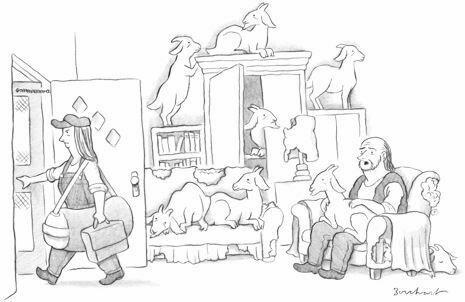

In [38]:
# 3) peek first
if judged_all:
    SAMPLE = 13


    j0 = judged_all[SAMPLE]
    print("\nFirst judged:")
    print(" conv_id:", j0.conversation_id)
    
    print(" user input:", j0.user_question)
    print(" category:", j0.category)
    print(" score:", j0.judge_score)
    print("orignal model:", j0.dataset_model)
    print(" justification:", j0.judge_justification)
    print("***************************************************************************************************")
    print("reference answer:", j0.reference_answer)
    print("***************************************************************************************************")
    print()
    print("model answer:", j0.model_answer)
    show_image(all_results[SAMPLE].images[0].get('bytes'))

#### Saving the Results

In [33]:
from common_utils.results import ResultsWriter

In [34]:
# from results_writer import ResultsWriter
writer = ResultsWriter(output_dir="outputs", prefix="common_qwen7b_eval_gemma27b_judge_1.json", timestamp=False)

# Save everything:
# paths = writer.save_all(
#     all_results=all_results,     # EvalOutput list
#     judged_all=judged_all,       # JudgedOutput list
#     buckets=buckets,             # raw selected records per category
# )

# print("Saved files:")
# for sect, files in paths.items():
#     for kind, p in files.items():
#         print(f"  {sect:8} {kind:12} -> {p}")

In [35]:
one_path = writer.save_one_json(
    eval_by_cat=results_by_cat,
    judged_by_cat=judged_by_cat,
    stem="combined"
)
